In [1]:
import matplotlib.pyplot as plt
import gensim
import numpy as np
import spacy
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
import pyLDAvis.gensim
import os, re, operator, warnings
warnings.filterwarnings('ignore') # Let's not pay heed to them right now
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np

In [3]:
path = 'yelp_data/health_text_sentiment_full.csv'

In [4]:
df = pd.read_csv(path)
df.drop(['Unnamed: 0'],axis=1,inplace=True)
df = df[['stars','clean_text']]
#df = df[['stars','text','clean_text']]

In [5]:
df.head()

,stars,clean_text
0,1,please stay away place bad care imaginable sta...
1,5,husband patient dr byrne last year half last m...
2,4,dr byrne great doctor great bed side manner ex...
3,3,raise review dr bryne receptive daughter go an...
4,1,wish could give star bad office ever horrible ...


##  five stars

In [6]:
one_star = df.ix[np.where(df.stars==1)]
one_star.reset_index(drop=True,inplace=True)
five_star = df.ix[np.where(df.stars==5)]
five_star.reset_index(drop=True,inplace=True)

In [8]:
five_star.head()

,stars,clean_text
0,5,husband patient dr byrne last year half last m...
1,5,dr byrne excellent doctor right skill include ...
2,5,go follow jacie example give run whole story f...
3,5,dr mario quesada arthroscopic knee surgery dr ...
4,5,love dr ravitch good knowledge awesome demeano...


## NLP

In [9]:
#nlp = spacy.load('en', parser=False, entity=False)
nlp = spacy.load('en')

In [ ]:
## test
test = one_star.loc[:100]
test.head()

In [ ]:
%%time
tokens = []
lemma = []
pos = []
for doc in nlp.pipe(test['clean_text'].astype('unicode').values, batch_size=50, n_threads=3):
    if doc.is_parsed:
        tokens.append([n.text for n in doc])
        lemma.append([n.lemma_ for n in doc])
        pos.append([n.pos_ for n in doc])
    else:
        # We want to make sure that the lists of parsed results have the
        # same number of entries of the original Dataframe, so add some blanks in case the parse fails
        tokens.append(None)
        lemma.append(None)
        pos.append(None)

test['tokens'] = tokens
test['lemma'] = lemma
test['POS'] = pos

In [ ]:
test.head()

## Five Star

In [10]:
five_star.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31726 entries, 0 to 31725
Data columns (total 2 columns):
stars         31726 non-null int64
clean_text    31726 non-null object
dtypes: int64(1), object(1)
memory usage: 495.8+ KB


In [11]:
five_star.head()

,stars,clean_text
0,5,husband patient dr byrne last year half last m...
1,5,dr byrne excellent doctor right skill include ...
2,5,go follow jacie example give run whole story f...
3,5,dr mario quesada arthroscopic knee surgery dr ...
4,5,love dr ravitch good knowledge awesome demeano...


## time

```
CPU times: user 59min 24s, sys: 6min 32s, total: 1h 5min 56s
Wall time: 8min 42s
    ```

In [12]:
%%time
lemma = []
for doc in nlp.pipe(five_star['clean_text'].astype('unicode').values, batch_size=50, n_threads=3):
    if doc.is_parsed:
        lemma.append([n.lemma_ for n in doc])
    else:
        # We want to make sure that the lists of parsed results have the
        # same number of entries of the original Dataframe, so add some blanks in case the parse fails
        lemma.append(None)

five_star['lemma'] = lemma

CPU times: user 55min 23s, sys: 5min 55s, total: 1h 1min 19s
Wall time: 7min 44s


In [13]:
fivestar_lemma = list(five_star.lemma)

## Bigram

In [14]:
%%time
bigram = gensim.models.Phrases(fivestar_lemma)

CPU times: user 3.92 s, sys: 281 ms, total: 4.2 s
Wall time: 4.21 s


In [15]:
%%time
texts = [bigram[line] for line in fivestar_lemma]

CPU times: user 10 s, sys: 531 ms, total: 10.6 s
Wall time: 10.6 s


In [16]:
texts[10]

['dr',
 'gibson',
 'absolutely_wonderful',
 'besides',
 'kind_hearted',
 'human',
 'wonderful',
 'gynecologist',
 'make_feel',
 'comfortable',
 'not',
 'comfortable',
 'situation',
 'knowledgeable',
 'helpful',
 'would_definitely',
 'recommend',
 'glad_find',
 'someone',
 'count',
 'year',
 'come']

In [17]:
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [18]:
len(corpus)

31726

In [19]:
corpus[10]

[(14, 1),
 (28, 1),
 (37, 1),
 (134, 1),
 (211, 1),
 (261, 1),
 (281, 1),
 (342, 1),
 (427, 1),
 (428, 1),
 (429, 2),
 (430, 1),
 (431, 1),
 (432, 1),
 (433, 1),
 (434, 1),
 (435, 1),
 (436, 1),
 (437, 1),
 (438, 1),
 (439, 1)]

## LSI

In [20]:
lsimodel = LsiModel(corpus=corpus, num_topics=10, id2word=dictionary)

In [21]:
lsimodel.show_topics(num_topics=5)

[(0,
  '0.428*"not" + 0.286*"dr" + 0.228*"go" + 0.227*"doctor" + 0.211*"time" + 0.206*"get" + 0.189*"see" + 0.181*"good" + 0.158*"office" + 0.151*"take"'),
 (1,
  '0.784*"dr" + -0.421*"not" + -0.180*"get" + -0.159*"go" + 0.136*"office" + 0.134*"staff" + 0.119*"care" + 0.087*"patient" + -0.076*"would" + 0.069*"always"'),
 (2,
  '0.490*"doctor" + -0.465*"dr" + -0.424*"not" + 0.257*"office" + 0.226*"time" + 0.201*"staff" + 0.184*"care" + 0.125*"great" + 0.118*"patient" + -0.111*"surgery"'),
 (3,
  '-0.610*"doctor" + -0.455*"not" + 0.281*"get" + 0.258*"go" + 0.175*"staff" + 0.156*"time" + 0.154*"great" + 0.130*"take" + 0.126*"back" + 0.097*"surgery"'),
 (4,
  '-0.492*"go" + -0.432*"doctor" + 0.386*"not" + 0.251*"office" + 0.248*"staff" + 0.233*"care" + 0.190*"time" + -0.174*"get" + -0.162*"see" + -0.140*"good"')]

## HDP

In [22]:
%%time
hdpmodel = HdpModel(corpus=corpus, id2word=dictionary)

CPU times: user 33min 29s, sys: 4min 19s, total: 37min 49s
Wall time: 4min 54s


In [23]:
 hdpmodel.show_topics()

[(0,
  '0.021*not + 0.015*dr + 0.012*doctor + 0.012*go + 0.012*time + 0.011*get + 0.010*good + 0.010*see + 0.010*staff + 0.009*office + 0.009*care + 0.008*take + 0.007*great + 0.006*would + 0.006*patient + 0.005*one + 0.005*need + 0.005*back + 0.005*come + 0.005*always'),
 (1,
  '0.019*not + 0.016*dr + 0.012*time + 0.012*doctor + 0.011*go + 0.011*staff + 0.010*good + 0.010*get + 0.010*see + 0.010*office + 0.009*care + 0.008*take + 0.008*great + 0.006*would + 0.006*patient + 0.006*one + 0.005*need + 0.005*come + 0.005*experience + 0.005*make'),
 (2,
  '0.020*not + 0.016*dr + 0.012*go + 0.011*doctor + 0.011*time + 0.010*good + 0.010*get + 0.009*see + 0.009*staff + 0.009*care + 0.008*office + 0.008*take + 0.007*great + 0.006*would + 0.006*patient + 0.005*one + 0.005*need + 0.005*make + 0.005*back + 0.005*come'),
 (3,
  '0.019*not + 0.017*dr + 0.012*go + 0.011*doctor + 0.011*staff + 0.011*time + 0.011*good + 0.010*get + 0.010*see + 0.009*care + 0.009*office + 0.008*take + 0.008*great + 0.0

## LDA

In [24]:
%%time
ldamodel = LdaModel(corpus=corpus, num_topics=10, id2word=dictionary)

CPU times: user 1min 10s, sys: 3.28 s, total: 1min 13s
Wall time: 46.8 s


In [25]:
lda_topics = ldamodel.show_topics(num_topics=5)

In [26]:
for i,j in lda_topics:
    print('TOPIC:{}\n\nresult:{}\n'.format(i,j))


TOPIC:6

result:0.019*"baby" + 0.018*"not" + 0.015*"love" + 0.014*"-PRON-" + 0.011*"go" + 0.011*"pregnancy" + 0.010*"good" + 0.010*"first" + 0.010*"great" + 0.010*"son"

TOPIC:0

result:0.025*"dr" + 0.012*"care" + 0.010*"see" + 0.009*"go" + 0.008*"year" + 0.007*"not" + 0.007*"good" + 0.006*"pain" + 0.006*"love" + 0.006*"time"

TOPIC:1

result:0.018*"treatment" + 0.011*"good" + 0.010*"dr_hall" + 0.009*"thank" + 0.008*"feel" + 0.007*"care" + 0.007*"dr" + 0.007*"time" + 0.006*"amazing" + 0.006*"not"

TOPIC:9

result:0.029*"surgery" + 0.018*"pain" + 0.016*"dr" + 0.015*"go" + 0.013*"get" + 0.012*"good" + 0.011*"back" + 0.009*"day" + 0.009*"great" + 0.009*"would"

TOPIC:2

result:0.031*"not" + 0.020*"get" + 0.017*"go" + 0.017*"time" + 0.016*"doctor" + 0.013*"see" + 0.013*"wait" + 0.012*"take" + 0.010*"office" + 0.009*"call"



In [27]:
from gensim.test.utils import datapath
# Save model to disk.
ldamodel.save('fivestar_lda.model')

In [28]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.031308  0.068870       1        1  28.594934
8      0.045022 -0.026812       2        1  13.672786
5      0.177646 -0.020932       3        1  11.869944
7      0.083334  0.037495       4        1  10.367647
3     -0.123454  0.034597       5        1   9.890707
9     -0.076665  0.042327       6        1   9.299570
4     -0.109101  0.082755       7        1   5.518444
6      0.076903  0.057811       8        1   5.335089
1     -0.074367 -0.075163       9        1   2.975413
0     -0.030626 -0.200948      10        1   2.475468, topic_info=     Category          Freq       Term         Total  loglift  logprob
term                                                                  
14    Default  24722.000000         dr  24722.000000  30.0000  30.0000
49    Default   5177.000000    surgery   5177.000000  29.0000  29.0000
112   Default  15939.000000      staff  15939.000000  28.0000  28.0000
7     Default  13227.000000       care  13227.000000  27.0000  27.0000
37    Default  27472.000000        not  27472.000000  26.0000  26.0000
226   Default  12977.000000     office  12977.000000  25.0000  25.0000
39    Default   3834.000000       pain   3834.000000  24.0000  24.0000
218   Default   6282.000000   friendly   6282.000000  23.0000  23.0000
239   Default   5305.000000       love   5305.000000  22.0000  22.0000
355   Default   7222.000000     always   7222.000000  21.0000  21.0000
219   Default  11594.000000      great  11594.000000  20.0000  20.0000
730   Default   2780.000000  treatment   2780.000000  19.0000  19.0000
292   Default   1571.000000       baby   1571.000000  18.0000  18.0000
23    Default   2417.000000   hospital   2417.000000  17.0000  17.0000
40    Default   8675.000000    patient   8675.000000  16.0000  16.0000
825   Default   3837.000000     -PRON-   3837.000000  15.0000  15.0000
13    Default  17865.000000     doctor  17865.000000  14.0000  14.0000
80    Default  15747.000000       good  15747.000000  13.0000  13.0000
901   Default   2316.000000        eye   2316.000000  12.0000  12.0000
20    Default  17080.000000         go  17080.000000  11.0000  11.0000
211   Default   5707.000000       year   5707.000000  10.0000  10.0000
356   Default   5613.000000    amazing   5613.000000   9.0000   9.0000
853   Default   3638.000000      nurse   3638.000000   8.0000   8.0000
436   Default   2687.000000  make_feel   2687.000000   7.0000   7.0000
963   Default   2926.000000  procedure   2926.000000   6.0000   6.0000
232   Default   6720.000000       wait   6720.000000   5.0000   5.0000
423   Default   2461.000000        son   2461.000000   4.0000   4.0000
1663  Default   1161.000000      glass   1161.000000   3.0000   3.0000
231   Default  16473.000000       time  16473.000000   2.0000   2.0000
52    Default   5151.000000      thank   5151.000000   1.0000   1.0000
...       ...           ...        ...           ...      ...      ...
14    Topic10    873.490112         dr  24722.781250   0.3558  -3.6928
848   Topic10     60.184834       mary    105.880615   3.1338  -6.3679
7     Topic10    426.812531       care  13227.347656   0.2650  -4.4090
211   Topic10    279.712463       year   5707.868164   0.6829  -4.8316
2484  Topic10     84.172310  henderson    269.522400   2.5350  -6.0325
192   Topic10    352.424194        see  14395.534180  -0.0111  -4.6005
39    Topic10    213.359314       pain   3834.630615   0.8099  -5.1024
20    Topic10    316.573120         go  17080.318359  -0.2894  -4.7078
239   Topic10    210.752945       love   5305.218262   0.4730  -5.1147
412   Topic10    145.125732       life   1861.833740   1.1470  -5.4877
80    Topic10    248.949356       good  15747.631836  -0.4485  -4.9481
40    Topic10    201.915970    patient   8675.691406  -0.0617  -5.1575
270   Topic10    191.029236        one   7376.246094   0.0451  -5.2129
37    Topic10    262.882629        not  274

## Topic coherence

In [29]:
%%time
lsitopics = [[word for word, prob in topic] for topicid, topic in lsimodel.show_topics(formatted=False)]
hdptopics = [[word for word, prob in topic] for topicid, topic in hdpmodel.show_topics(formatted=False)]
ldatopics = [[word for word, prob in topic] for topicid, topic in ldamodel.show_topics(formatted=False)]

CPU times: user 1.86 s, sys: 547 ms, total: 2.41 s
Wall time: 1.03 s


In [30]:
%%time
lsi_coherence = CoherenceModel(topics=lsitopics[:10], texts=texts, dictionary=dictionary, window_size=10).get_coherence()
hdp_coherence = CoherenceModel(topics=hdptopics[:10], texts=texts, dictionary=dictionary, window_size=10).get_coherence()
lda_coherence = CoherenceModel(topics=ldatopics, texts=texts, dictionary=dictionary, window_size=10).get_coherence()

CPU times: user 7.56 s, sys: 8.16 s, total: 15.7 s
Wall time: 32.6 s


In [31]:
def evaluate_bar_graph(coherences, indices):
    """
    Function to plot bar graph.
    coherences: list of coherence values
    indices: Indices to be used to mark bars. Length of this and coherences should be equal.
    """
    assert len(coherences) == len(indices)
    n = len(coherences)
    x = np.arange(n)
    plt.bar(x, coherences, width=0.2, tick_label=indices, align='center')
    plt.xlabel('Models')
    plt.ylabel('Coherence Value')

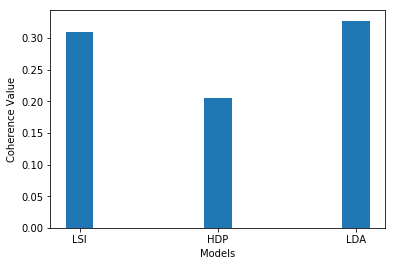

In [32]:
evaluate_bar_graph([lsi_coherence, hdp_coherence, lda_coherence],
['LSI', 'HDP', 'LDA'])

In [33]:
def evaluate_graph(dictionary, corpus, texts, limit):
    """
    Function to display num_topics - LDA graph using c_v coherence
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit
    Returns:
    -------
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    c_v = []
    lm_list = []
    for num_topics in range(1, limit):
        lm = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        lm_list.append(lm)
        cm = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v.append(cm.get_coherence())
    # Show graph
    x = range(1, limit)
    plt.plot(x, c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()
    
    return lm_list, c_v

In [ ]:
%%time
lmlist, c_v = evaluate_graph(dictionary=dictionary, corpus=corpus, texts=texts, limit=10)